# Comparative study of Geomstat & PyRiemann frameworks

We compare the 2 frameworks on differents datasets for different metrics, and plot both classification scores and computation time.

### Imports

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import yaml
import seaborn as sns
from mne.decoding import CSP



from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline


# Dimension reduction

# Covariance estimation
from mne import compute_covariance as mne_cov
from pyriemann.estimation import Covariances as pyr_cov
from pyriemann.estimation import XdawnCovariances as pyr_xdawn_cov

# Transformations
from pyriemann.tangentspace import TangentSpace as pyr_ts
from geomstats.learning.preprocessing import ToTangentSpace as geo_ts


# Metrics
from geomstats.geometry.spd_matrices import SPDMetricLogEuclidean
from geomstats.geometry.riemannian_metric import RiemannianMetric


# Classification algorithms
from pyriemann.classification import MDM
from sklearn.svm import SVC



# Framework

import moabb
from moabb.datasets import AlexMI, BNCI2014001, BNCI2014002, BNCI2014004, BNCI2015001, BNCI2015004, Cho2017, Lee2019_MI, MunichMI, Ofner2017, PhysionetMI, Schirrmeister2017, Shin2017A, Shin2017B, Weibo2014, Zhou2016
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import MotorImagery

In [2]:
moabb.set_log_level("info")
warnings.filterwarnings("ignore")


In [3]:
def read_yaml(yaml_path):
    """Open and read safely a yaml file."""
    with open(yaml_path, 'r') as stream:
        try:
            parameters = yaml.safe_load(stream)
        except :
            print("Couldn't load yaml file: {}.".format(yaml_path))
            quit()
    return parameters

### Test Samples (Datasets - subjects)

As a sample dataset, we use:
- moabb.datasets.AlexMI



This Dataset contains EEG recordings from 8 subjects, performing 2 task of motor imagination (right hand, feet or rest). Data have been recorded at 512Hz with 16 wet electrodes (Fpz, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, Pz, P4, P8) with a g.tec g.USBamp EEG amplifier.

File are provided in MNE raw file format. A stimulation channel encoding the timing of the motor imagination. The start of a trial is encoded as 1, then the actual start of the motor imagination is encoded with 2 for imagination of a right hand movement, 3 for imagination of both feet movement and 4 with a rest trial.

The duration of each trial is 3 second. There is 20 trial of each class.


In [4]:
dataset_list = read_yaml('datasets.yml')
datasets_names = [list(i.keys())[0] for i in dataset_list['motor_imagery_datasets']]

{1: {'session_0': {'run_0': <Raw | subject1.raw.fif, 17 x 254785 (497.6 s), ~33.1 MB, data loaded>}}}


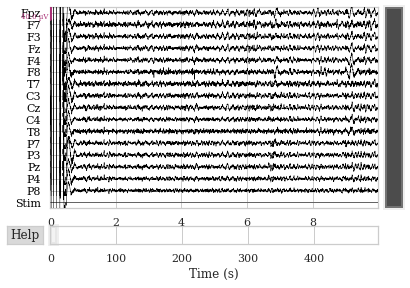

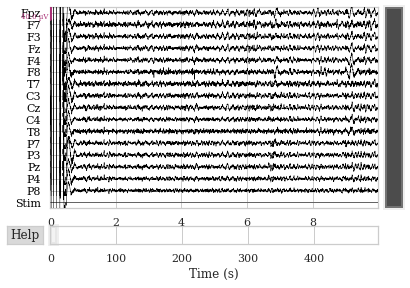

In [6]:
dataset = AlexMI()
sessions = dataset.get_data(subjects=[1])
print(sessions)
subject = 1
session_name = "session_0"
run_name = "run_0"
raw = sessions[subject][session_name][run_name]
events = mne.find_events(raw, stim_channel='Stim')
raw.plot()

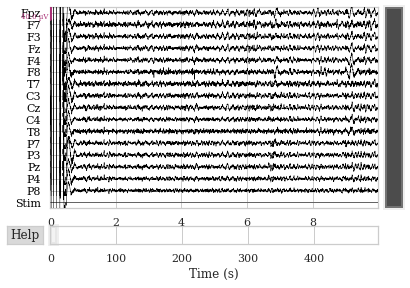

<Raw | subject1.raw.fif, 17 x 254785 (497.6 s), ~33.1 MB, data loaded>


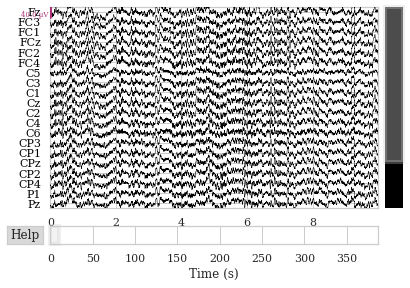

<RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>


ValueError: No stim channel found to extract event triggers.

In [36]:
session_names = ["session_0", "session_T", "session_0", "session_0", "session_A"]
datasets = [AlexMI(), BNCI2014001(), BNCI2014002(), BNCI2014004(), BNCI2015001(), BNCI2015004(), Cho2017(), Lee2019_MI(), MunichMI(), Ofner2017(), PhysionetMI(), Schirrmeister2017(), Shin2017A(), Shin2017B(), Weibo2014(), Zhou2016()]

for dataset, session_name in zip(datasets[:5], session_names[:5]):
    sessions = dataset.get_data(subjects=[1])
    subject = 1
    run_name = "run_0"
    raw = sessions[subject][session_name][run_name]
    raw.plot()
    events = mne.find_events(raw, stim_channel='Stim')

In [13]:

pipelines = {}

#pipelines["pyr_xdawn_cov+MDM"] = make_pipeline(pyr_xdawn_cov(), MDM(metric="riemann"))
pipelines["pyr_cov+MDM"] = make_pipeline(pyr_cov(), MDM(metric="riemann"))
pipelines["pyr_cov+TS-riemann+SVC"] = make_pipeline(pyr_cov(), TangentSpace(metric="riemann"), SVC(kernel="linear"))
pipelines["pyr_cov+TS-logeuclid+SVC"] = make_pipeline(pyr_cov(), TangentSpace(metric="logeuclid"), SVC(kernel="linear"))
pipelines["pyr_cov+geo_TS-log-eucli-25+SVC"] = make_pipeline(pyr_cov(),  ToTangentSpace(geometry=SPDMetricLogEuclidean(25)), SVC(kernel="linear"))
#pipelines["pyr_cov+geo_TS-rieman+SVC"] = make_pipeline(pyr_cov(), ToTangentSpace(geometry=RiemannianMetric(25)), SVC(kernel="linear"))





paradigm = MotorImagery(
    events=list(dataset.event_id.keys()), 
    n_classes=3,
    fmin=8,
    fmax=25,
    tmin=0,
    tmax=3,
    baseline=None,
    channels=None
)

#epochs.get_data()[:, :-1, :].shape

evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=[dataset],
    overwrite=True,
    hdf5_path=None,
)
results = evaluation.process(pipelines)


2021-09-20 17:10:36,924 INFO MainThread moabb.evaluations.base Processing dataset: Alexandre Motor Imagery
2021-09-20 17:10:37,699 INFO MainThread moabb.evaluations.base pyr_cov+MDM | Alexandre Motor Imagery | 1 | session_0: Score 0.617
2021-09-20 17:10:38,228 INFO MainThread moabb.evaluations.base pyr_cov+TS-riemann+SVC | Alexandre Motor Imagery | 1 | session_0: Score 0.617
2021-09-20 17:10:38,394 INFO MainThread moabb.evaluations.base pyr_cov+TS-logeuclid+SVC | Alexandre Motor Imagery | 1 | session_0: Score 0.600
2021-09-20 17:10:38,552 INFO MainThread moabb.evaluations.base pyr_cov+geo_TS-log-eucli-25+SVC | Alexandre Motor Imagery | 1 | session_0: Score 0.550
2021-09-20 17:10:39,283 INFO MainThread moabb.evaluations.base pyr_cov+MDM | Alexandre Motor Imagery | 2 | session_0: Score 0.700
2021-09-20 17:10:39,809 INFO MainThread moabb.evaluations.base pyr_cov+TS-riemann+SVC | Alexandre Motor Imagery | 2 | session_0: Score 0.800
2021-09-20 17:10:39,985 INFO MainThread moabb.evaluations.

In [14]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.616667,0.103682,60.0,1,session_0,16,1,Alexandre Motor Imagery,pyr_cov+MDM
1,0.700000,0.098664,60.0,2,session_0,16,1,Alexandre Motor Imagery,pyr_cov+MDM
2,0.716667,0.100249,60.0,3,session_0,16,1,Alexandre Motor Imagery,pyr_cov+MDM
3,0.483333,0.102284,60.0,4,session_0,16,1,Alexandre Motor Imagery,pyr_cov+MDM
4,0.483333,0.097230,60.0,5,session_0,16,1,Alexandre Motor Imagery,pyr_cov+MDM
5,0.550000,0.098078,60.0,6,session_0,16,1,Alexandre Motor Imagery,pyr_cov+MDM
6,0.850000,0.091831,60.0,7,session_0,16,1,Alexandre Motor Imagery,pyr_cov+MDM
7,0.750000,0.101595,60.0,8,session_0,16,1,Alexandre Motor Imagery,pyr_cov+MDM
8,0.600000,0.031497,60.0,1,session_0,16,1,Alexandre Motor Imagery,pyr_cov+TS-logeuclid+SVC
9,0.750000,0.033626,60.0,2,session_0,16,1,Alexandre Motor Imagery,pyr_cov+TS-logeuclid+SVC


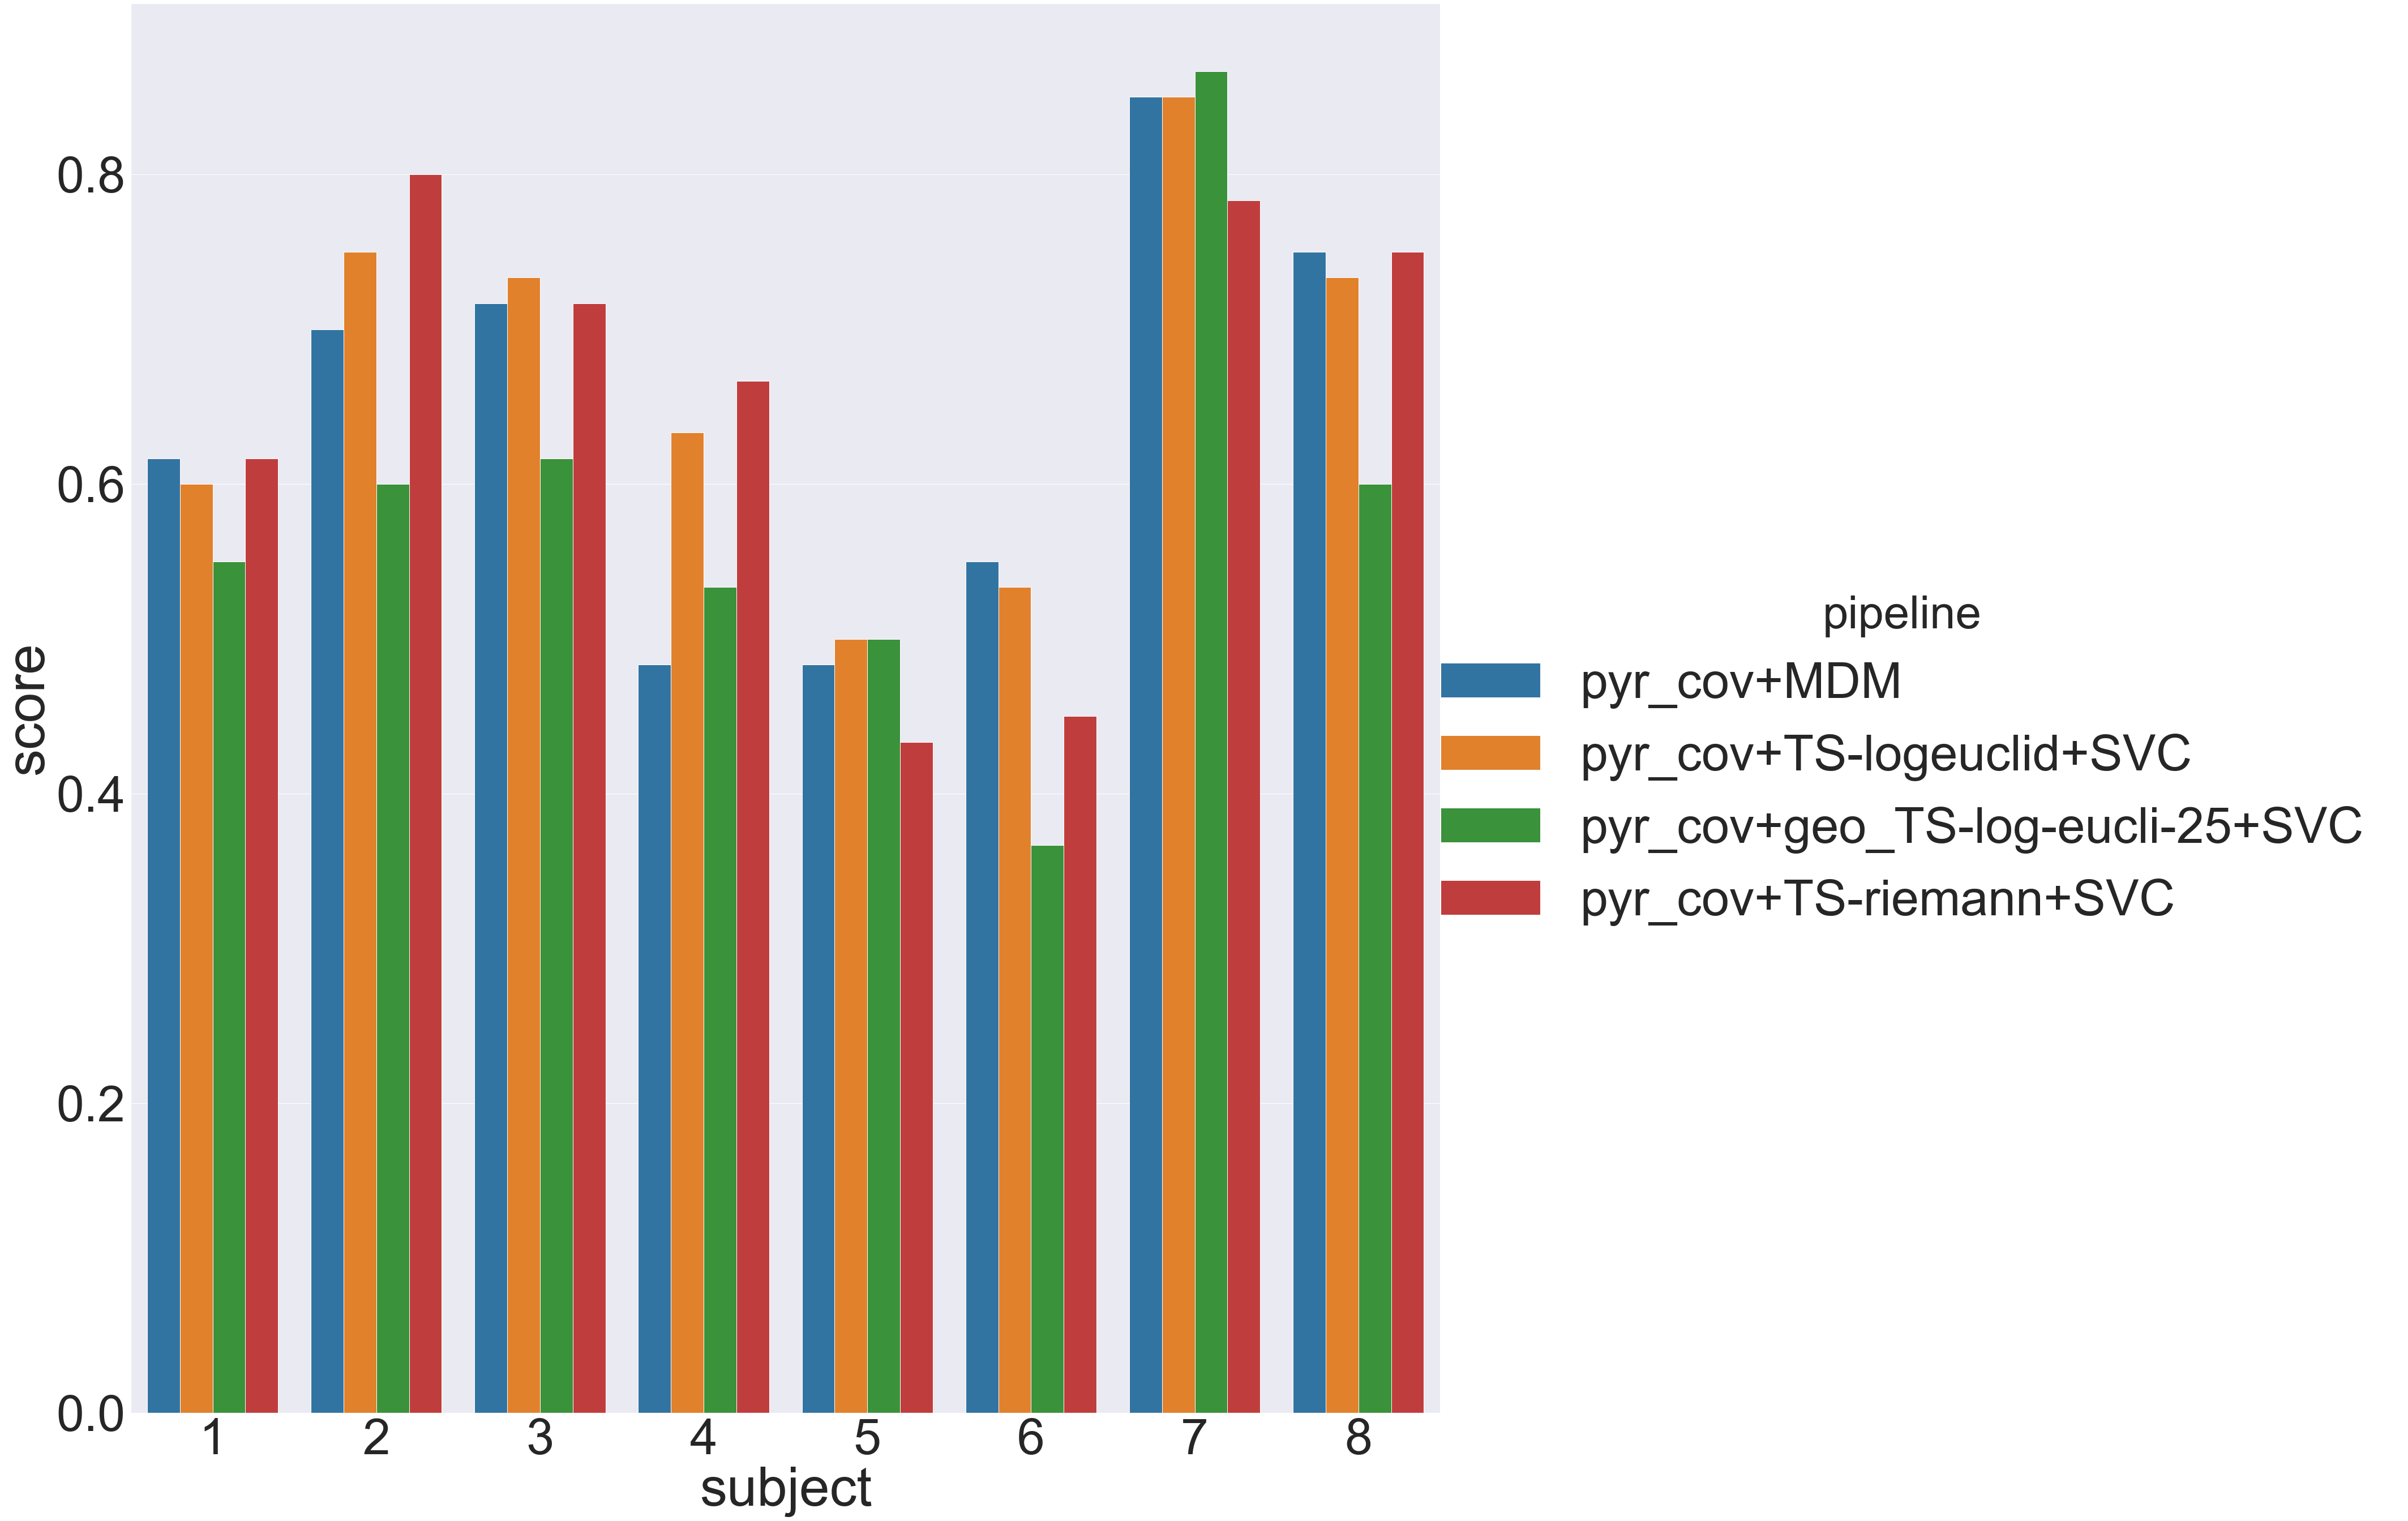

In [15]:
sns.set(font_scale = 8)
g = sns.catplot(
    kind="bar",
    y="score",
    x="subject",
    hue="pipeline",
    data=results,
    #orient="h",
    palette="tab10",
    height=40, 
)
#g.set_xticklabels(plt.get_xticklabels(), fontsize = 18)
plt.show()

In [104]:
tmin = 0
tmax = 3
proj = True # à faire varier

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    dataset.event_id,
    tmin,
    tmax,
    proj=proj,
    picks=None,
    baseline=None,
    preload=True,
    verbose=False,
)


In [108]:
epochs.get_data()[:, :-1, :].shape

(60, 16, 1537)

### Datasets preprocessing

Computing covariances matrices:

In [67]:
data = raw.get_data()
(Ne, Ns) = data.shape
data = data.reshape(1, Ne, Ns) # introduce Number of trials dimension
m = Covariances().fit_transform(data)

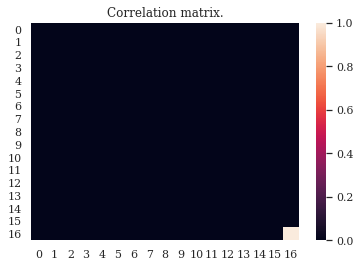

In [68]:
sns.heatmap(np.squeeze(m), vmin=0, vmax=1)

plt.title("Correlation matrix.")
plt.show()

### Creating Pipeline

In [163]:
pipelines = {}

#nfilter = 4
#xdwn = XdawnCovariances(estimator='scm', nfilter=nfilter)
#split = train_test_split(X, y, train_size=0.25, random_state=42)
#Xtrain, Xtest, ytrain, ytest = split
#covs = xdwn.fit(Xtrain, ytrain).transform(Xtest)
#
#lapl = Embedding(metric='riemann', n_components=2)
#embd = lapl.fit_transform(covs)
#

from mne import compute_covariance as mne_cov
from pyriemann.estimation import XdawnCovariances as pyr_xdawn_cov
from pyriemann.estimation import Covariances as pyr_cov

#pipelines["mne_cov+MDM"] = make_pipeline(mne_cov, MDM(metric="riemann"))
pipelines["pyr_xdawn_cov+MDM"] = make_pipeline(pyr_xdawn_cov(), MDM(metric="riemann"))
pipelines["pyr_cov+MDM"] = make_pipeline(pyr_cov(), MDM(metric="riemann"))


### Evaluation

In [ ]:
#evaluation = CrossSessionEvaluation(
#    paradigm=dataset.paradigm, datasets=[dataset], suffix="examples", overwrite=False
#)
#results = evaluation.process(pipelines)

In [151]:
paradigm.get_data(dataset)

SHA256 hash of downloaded file: 24d5a755da7884424b3fa7318d7decc2b42098a30cda9c8da45231ae14e88a39
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 0ae95dac4c432cf4ecc7fb225593a84ffa6a4049c2d4f77fccc8b93e1ee85734
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 0bcd939780b098bf889da8b2bd882891ddc339dadd0b9b2f6cb659d3d40b73f8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: e9eef9c93bd2157940fa6681dbea27ce37ec9cbd890e21c8fb91f6a1aea2bc87
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 2cfa

KeyError: 'padlen'

In [164]:
X = epochs.get_data()[:, :-1, :]
y = events[events[:, 1]==1][:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [165]:
paradigm = MotorImagery(
    #events=list(dataset.event_id.keys()), 
    #n_classes=3,
    fmin=None,
    fmax=None,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    channels=None
)

#epochs.get_data()[:, :-1, :].shape

for pipe in pipelines:
    pipelines[pipe].fit(X_train, y_train)
    print(pipelines[pipe].score(X_test, y_test))


#evaluation = WithinSessionEvaluation(
#    paradigm=paradigm,
#    datasets=[dataset],
#    overwrite=True,
#    hdf5_path=None,
#)
#results = evaluation.process(pipelines)


2021-09-20 15:41:18,213 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


0.3333333333333333
0.26666666666666666


In [135]:
#results.to_csv("./results_part2-1.csv")
#results = pd.read_csv("./results_part2-1.csv")

### Plotting results

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
fig.show()

In [ ]:
results["subj"] = [str(resi).zfill(2) for resi in results["subject"]]
g = sns.catplot(
    kind="bar",
    x="score",
    y="subj",
    col="dataset",
    data=results,
    orient="h",
    palette="viridis",
)
plt.show()